In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('../src/')
from Biologging_Toolkit.applications.Rain import Rain
from Biologging_Toolkit.applications.Wind import Wind
import Biologging_Toolkit.utils.rain_empirical_utils as R_Utils

d:\STAGE\ENSTA\SES_tags\notebooks\../src\Biologging_Toolkit


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import pickle
from scipy.stats import *
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "text.usetex": True  
})

In [3]:
path = os.path.join(r"G:\individus_filtered")
depids_wo293 = ['ml17_280a','ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_296b','ml20_313a','ml21_295a','ml21_305b'] #'ml20_293a',

---
# Creation du jeu de donnée CSV

In [4]:
def calculate_and_add_slope(df, freq1, freq2):
    slope_column_name = f"slope_{freq1}_{freq2}"
    spl1 = df[f'upwards_mean_{freq1}']
    spl2 = df[f'upwards_mean_{freq2}']
    delta_spl = spl2 - spl1
    delta_log_freq = np.log10(freq2) - np.log10(freq1)
    slope = delta_spl / delta_log_freq
    df[slope_column_name] = slope 
    return df
              
def get_reduced_df(path) :
    df_csv = pd.read_csv(r"C:\Users\robin\Downloads\annotation_pluie - Sheet1.csv")
    df_csv.head()
    df = pd.DataFrame([])
    selected_rows = []

    for depid in df_csv['depid'].unique():
        _df = pd.read_csv(os.path.join(path, depid, f"{depid}_dive.csv"))
        rows = df_csv[df_csv['depid'] == depid]

        for _, row in rows.iterrows():
            _df.loc[_df["dive"]==row["acoustic"], "precipitation_GPM"] = _df.loc[_df["dive"]==row["rain"], "precipitation_GPM"].values
            selected = _df.loc[_df["dive"]==row["acoustic"]].copy()
            selected['depid'] = depid
            wind_tresh = 7
            conditions = [
                (selected["precipitation_GPM"] > 0.1) & (selected["wind_speed"] < wind_tresh),
                (selected["precipitation_GPM"] > 0.1) & (selected["wind_speed"] >= wind_tresh),
            ]
            choices = ["R", "WR"]#, "W"]
            selected["weather"] = np.select(conditions, choices, default="N")
            selected_rows.append(selected)
    
    return pd.concat(selected_rows, ignore_index=True)

def create_noRain(path):
    selected_rows = []
    df_csv = pd.read_csv(r"C:\Users\robin\Downloads\annotation_pluie - Sheet1.csv")
    keys = df_csv['depid'].value_counts().keys()
    values = df_csv['depid'].value_counts().values
    for depid, y in zip(keys,values):
        _df = pd.read_csv(os.path.join(path, depid, f"{depid}_dive.csv"))
        noRain = _df.loc[_df['precipitation_GPM'] < 0.1].copy()
        
        wind_tresh = 7
        conditions = [
                (noRain["precipitation_GPM"] > 0.1) & (noRain["wind_speed"] < wind_tresh),
                (noRain["precipitation_GPM"] > 0.1) & (noRain["wind_speed"] >= wind_tresh),
            ]
        choices = ["R", "WR"]
        
        noRain["weather"] = np.select(conditions, choices, default="N")
        noRain['depid'] = depid

        for i in range(y):
            row = noRain.sample(n=1, random_state=1+i)
            selected_rows.append(row)

    return pd.concat(selected_rows, ignore_index=True)

In [5]:
df_alldepids = pd.DataFrame({})
for depid in depids_wo293 :
    df = pd.read_csv(os.path.join(path, depid, f"{depid}_dive.csv"))
    df = df.dropna(subset=["upwards_mean_8000", "precipitation_GPM","wind_speed"])
    df_alldepids = pd.concat([df, df_alldepids])

In [6]:
df_reduced = get_reduced_df(path)
dfNoRain = create_noRain(path)

df = pd.concat([df_reduced, dfNoRain], ignore_index=True)

df = calculate_and_add_slope(df,2000,8000)
df = calculate_and_add_slope(df, 8000,15000)

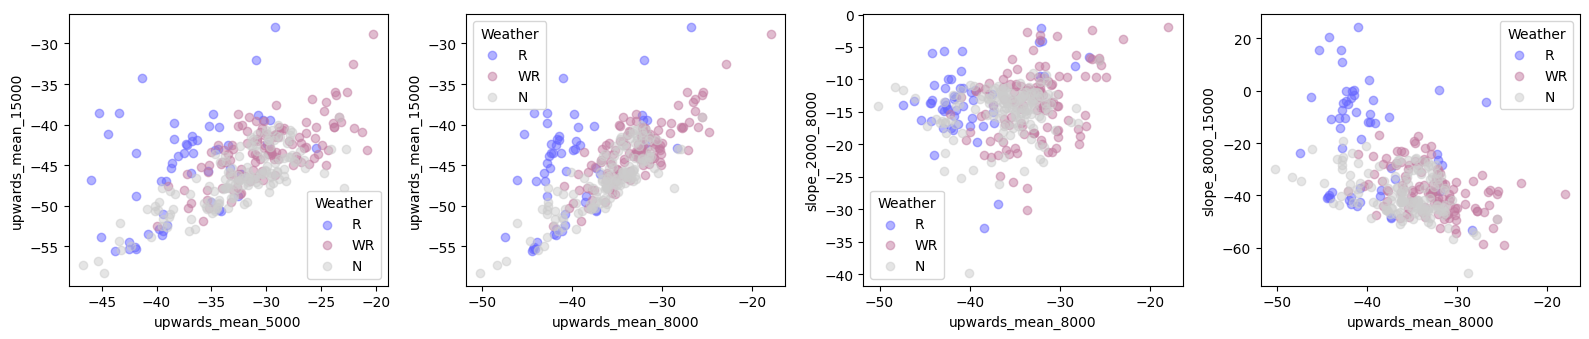

In [108]:
R_Utils.plot_spl_rain(df)

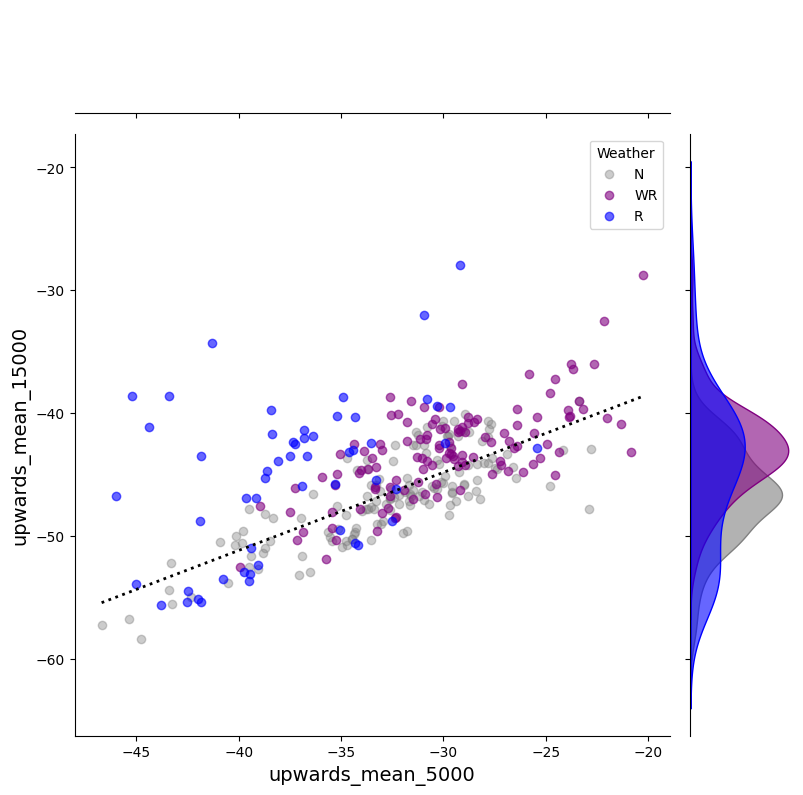

upwards_mean_15000 = 0.635603217124692*upwards_mean_5000 - 25.7613226425985
y = 0.6356032171246919 * x + -25.76132264259846


In [109]:
R_Utils.plot_weather_SPL_regression(df,x = "upwards_mean_5000", y = "upwards_mean_15000", height=8)

---
# NPZ

In [161]:
def calculate_slope_spectrogram(spectro, freqs, freq1, freq2):
    idx1 = np.argmin(np.abs(freqs - freq1))
    idx2 = np.argmin(np.abs(freqs - freq2))
    spl1 = spectro[:, idx1].mean()
    spl2 = spectro[:, idx2].mean()
    delta_spl = spl2 - spl1
    delta_log_freq = np.log10(freqs[idx2]) - np.log10(freqs[idx1])
    slope = delta_spl / delta_log_freq
    return slope

In [14]:
X,y = [], []
ws, rr = [], []
flag = False
for _, row in df.iterrows():
    depid = row["depid"]
    dive = int(row["dive"])
    
    npz_path = os.path.join(path, depid, "dives", f'acoustic_dive_{dive:05}.npz')
    npz = np.load(npz_path)

    data = {
        "freq": npz["freq"],
        "spectro": npz["spectro"].astype(np.float32, copy=False),
        "depth": npz["depth"].astype(np.float32, copy=False),
        "label": row["precipitation_GPM"],
        "windspeed": row["wind_speed"]
    }

    if not flag:
        freq = data["freq"]
        flag = True

    data["spectro"] = data["spectro"]
    mask = data["depth"]>10
    data["spectro"] = data["spectro"][mask]
    # data = appliquer_pipeline(data, processing_steps, idx)

    X.append(data["spectro"])
    ws.append(data["windspeed"])
    rr.append(data["label"])
    npz_freqs = data["freq"]

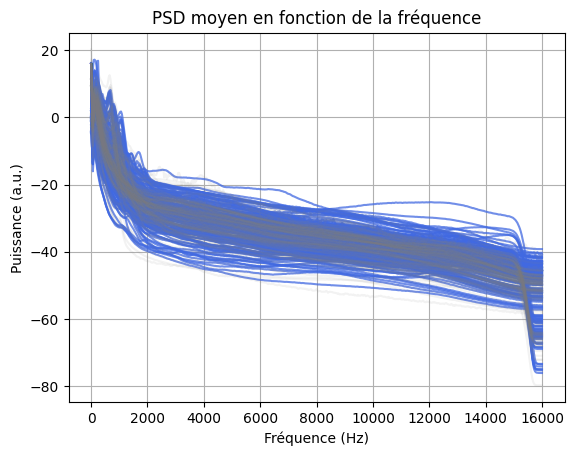

In [127]:
for i in range(len(X)):
    psd = X[i].mean(axis=0)
    plt.plot(data["freq"], psd, alpha=0.1 if y[i]<0.1 else 0.75, c="royalblue" if y[i]>0.1 else "grey")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Puissance (a.u.)")
plt.title("PSD moyen en fonction de la fréquence")
plt.grid(True)
plt.show()

---
# PCA

In [42]:
print(len(df))
df = df.dropna(subset=[f'upwards_mean_{freq}' for freq in [2000, 5000, 8000, 10000, 12000, 15000]])
print(len(df))
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[[f'upwards_mean_{freq}' for freq in [2000, 5000, 8000, 10000, 12000, 15000]]])

318
318


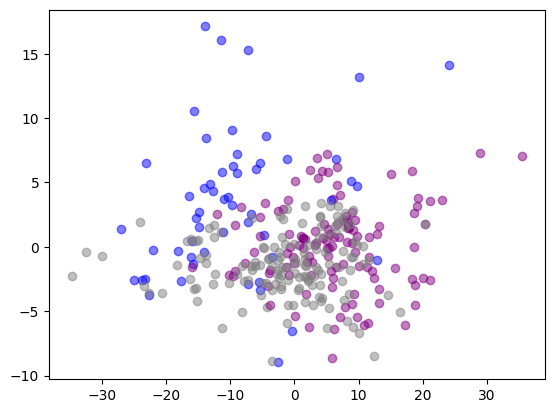

In [46]:
for elem, w in zip(df_pca, df['weather']): 
    plt.scatter(elem[0], elem[1], c='b' if w=='R' else ('purple' if w=='WR' else 'grey'), alpha=0.5)

---
# CatBoost

In [100]:
from catboost import CatBoostRegressor, Pool
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [90]:

def normalize_spectrogram_length(spectro, target_len=550):
    n_time, n_freq = spectro.shape
    
    if n_time > target_len:
        spectro_new = spectro[-target_len:, :]
    elif n_time < target_len:
        pad_len = target_len - n_time
        padding = np.zeros((pad_len, n_freq))
        spectro_new = np.vstack([padding, spectro])
    else:
        spectro_new = spectro
    
    return spectro_new
def average_by_band(spectrogram, freqs, band_size=1000):
    max_freq = freqs.max()
    bands = np.arange(0, max_freq + band_size, band_size)
    
    band_means = []
    for i in range(len(bands) - 1):
        fmin, fmax = bands[i], bands[i+1]
        idx = np.where((freqs >= fmin) & (freqs < fmax))[0]
        
        if len(idx) > 0:
            band_means.append(spectrogram[:, idx].mean(axis=1)) 
        else:
            band_means.append(np.zeros(spectrogram.shape[0]))  
    
    return np.stack(band_means, axis=1)
def average_time_bands(spectrogram, n_bands=17):
    n_time, n_freq = spectrogram.shape
    band_size = int(np.ceil(n_time / n_bands)) 
    
    bands = []
    for i in range(n_bands):
        start = i * band_size
        end = min((i + 1) * band_size, n_time)
        band = spectrogram[start:end, :]
        bands.append(band.mean(axis=0))
    
    return np.stack(bands, axis=0)


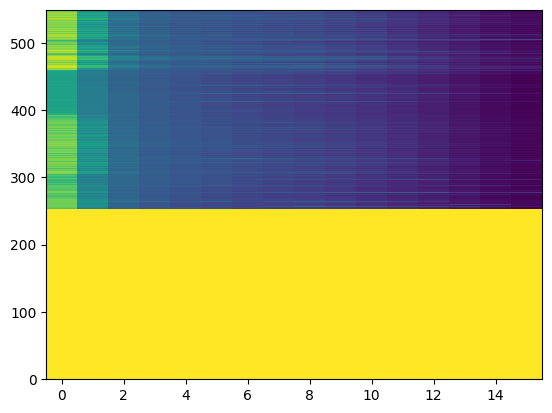

In [91]:
X = np.array([normalize_spectrogram_length(x) for x in X])
X = np.array([average_by_band(x, freq) for x in X])
# X = np.array([average_time_bands(x) for x in X])
plt.imshow(X[0], aspect='auto', origin='lower',interpolation="none")
plt.show()


In [92]:
X = np.array([x.flatten() for x in X])
print(X.shape)

(372, 8800)


In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
# RMSE, MultiRMSE, SurvivalAft, MAE, Quantile, LogLinQuantile, Poisson, MAPE, Lq
model = CatBoostRegressor(iterations=1000,
                          depth=8,
                          learning_rate=0.1,
                          loss_function='RMSE',
                          verbose=100)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

0:	learn: 2.0389313	total: 263ms	remaining: 4m 22s
100:	learn: 0.1644015	total: 1m 4s	remaining: 9m 36s
200:	learn: 0.0675506	total: 2m 13s	remaining: 8m 50s
300:	learn: 0.0658050	total: 3m 20s	remaining: 7m 45s
400:	learn: 0.0657605	total: 4m 27s	remaining: 6m 40s
500:	learn: 0.0657577	total: 5m 36s	remaining: 5m 35s
600:	learn: 0.0657574	total: 6m 48s	remaining: 4m 31s
700:	learn: 0.0657574	total: 8m 2s	remaining: 3m 25s
800:	learn: 0.0657574	total: 9m 23s	remaining: 2m 19s
900:	learn: 0.0657574	total: 10m 35s	remaining: 1m 9s
999:	learn: 0.0657574	total: 11m 46s	remaining: 0us


(-0.5, 14.141508117872634)

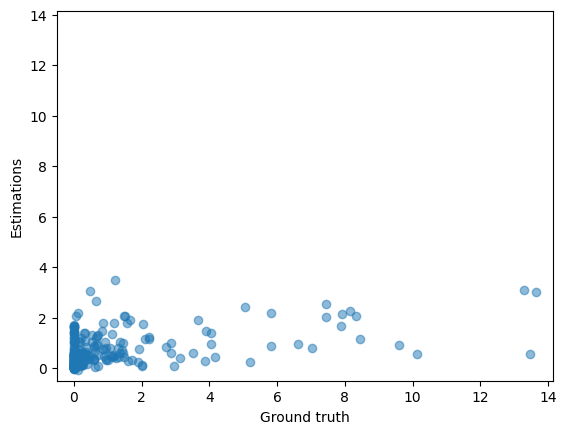

In [99]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Ground truth")
plt.ylabel("Estimations")
plt.xlim(-0.5, max(np.max(y_test),np.max(y_pred))+0.5)
plt.ylim(-0.5, max(np.max(y_test),np.max(y_pred))+0.5)

---
# SVM

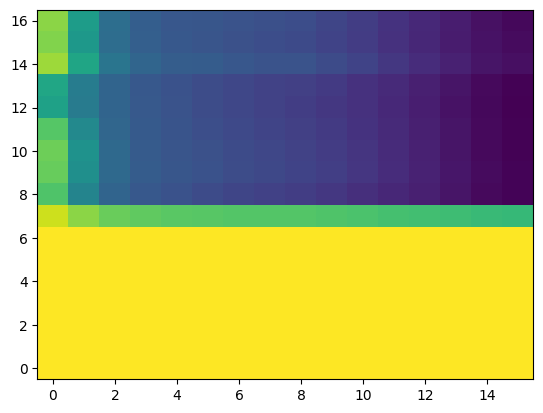

In [163]:
X = np.array([normalize_spectrogram_length(x) for x in X])
X = np.array([average_by_band(x, freq) for x in X])
X = np.array([average_time_bands(x) for x in X])
plt.imshow(X[0], aspect='auto', origin='lower',interpolation="none")
plt.show()

X = np.array([x.flatten() for x in X])

X = np.array(X)
y = np.array(y)
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42
)

In [172]:
param_grid = {
    'C': [0.1, 1, 10,100,1000,10000],
    'epsilon': [0.01, 0.1, 0.2,0.5,1,2,5],
    'gamma': ['scale', 0.01, 0.1, 1,10,100]
}

svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=50, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)

Best params: {'C': 10, 'epsilon': 1, 'gamma': 'scale'}


In [177]:

svm_model = SVR(
    kernel='poly', degree=3,   
    C=10,          
    epsilon=1,    
    gamma="scale" 
)

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

(-0.5, 14.141508117872634)

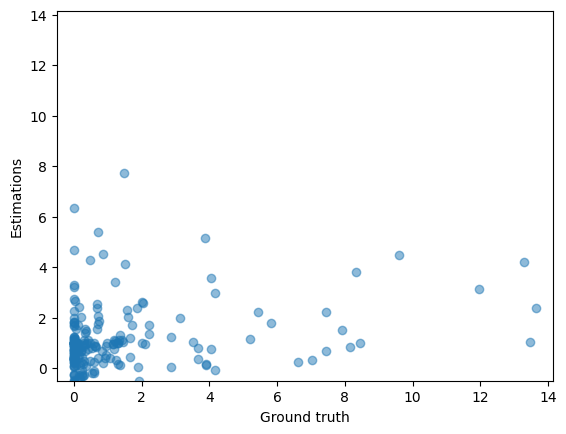

In [178]:
plt.scatter(y_test, y_pred_svm, alpha=0.5)
plt.xlabel("Ground truth")
plt.ylabel("Estimations")
plt.xlim(-0.5, max(np.max(y_test),np.max(y_pred))+0.5)
plt.ylim(-0.5, max(np.max(y_test),np.max(y_pred))+0.5)

---
# W1M3A

In [7]:
raw_timestamp_UPA, raw_SPL64 = pickle.load(open(os.path.join('G:/W1M3A','UPA_all.sav'), 'rb'))
weather = pd.read_csv(os.path.join('G:/W1M3A','rain_and_wind.csv'))
freqs = [100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900, 2100, 2200, 2400, 2600, 2800, 3000, 3600, 4600, 5600, 6500, 7500, 8500, 9500, 10400, 11400, 12400, 13400, 14400, 15300, 16300, 17300, 18300, 19200, 20200, 21200, 22200, 23100, 24100, 25100, 26100, 27100, 28000, 29000, 30000, 31000, 31900, 32900, 33900, 34900, 35800, 36800, 37800, 38800, 39700, 40700, 41700, 42700, 43700, 44600, 45600, 46600, 47600, 48500, 49500]
print(weather.columns)

Index(['Unnamed: 0', 'timestamp', 'windSpeed_W1M3A', 'rainfall_W1M3A'], dtype='object')


In [8]:

raw_timestamp_UPA = pd.to_datetime(raw_timestamp_UPA).values
weather_ts = pd.to_datetime(weather['timestamp']).values
weather['timestamp'] = pd.to_datetime(weather['timestamp'])
raw_SPL64 = np.array(raw_SPL64)

timestamp_UPA = []
SPL64 = []

for ts in weather_ts:
    idx = np.argmin(np.abs(raw_timestamp_UPA - ts))
    timestamp_UPA.append(raw_timestamp_UPA[idx])
    SPL64.append(raw_SPL64[idx])
SPL64 = np.array(SPL64)

In [9]:
print(len(timestamp_UPA), len(SPL64), len(weather)) 

14320 14320 14320


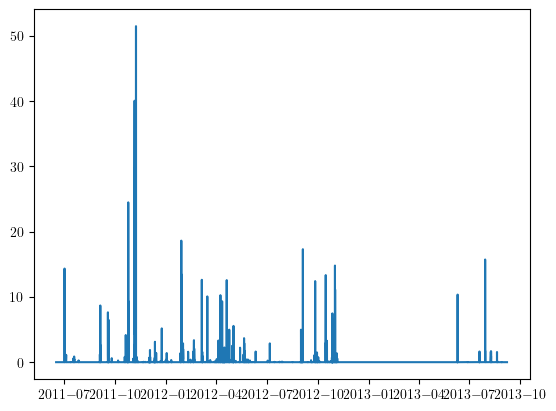

In [10]:
plt.plot(weather["timestamp"], weather["rainfall_W1M3A"], label="Rain (mm/h)")

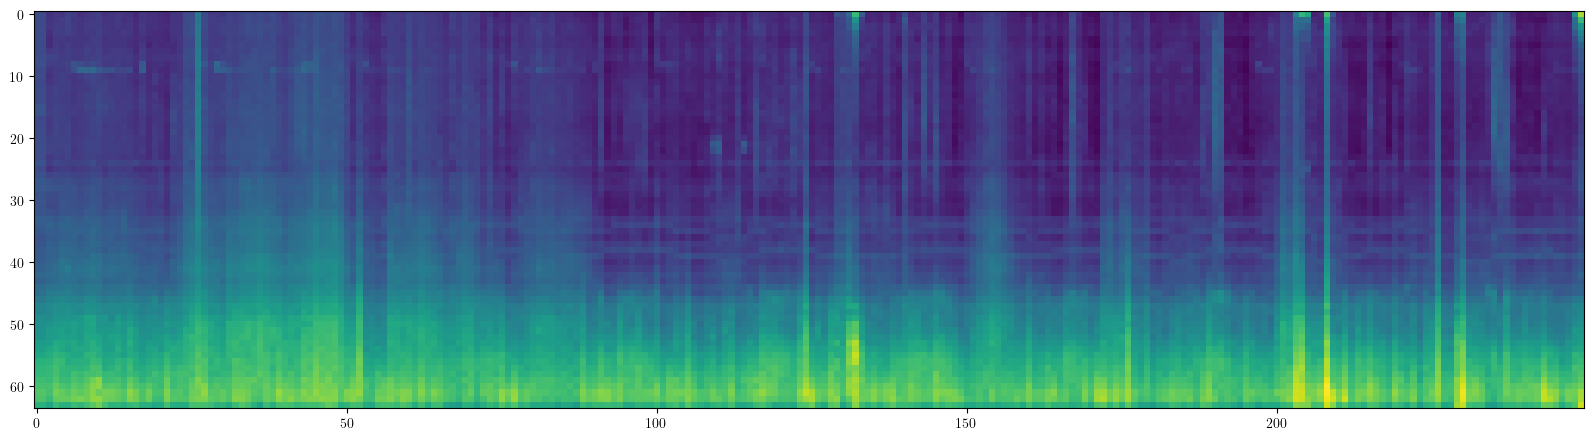

In [11]:
plt.figure(figsize=(20, 6))
plt.imshow(np.fliplr(SPL64[0:250]).T)

20 7500


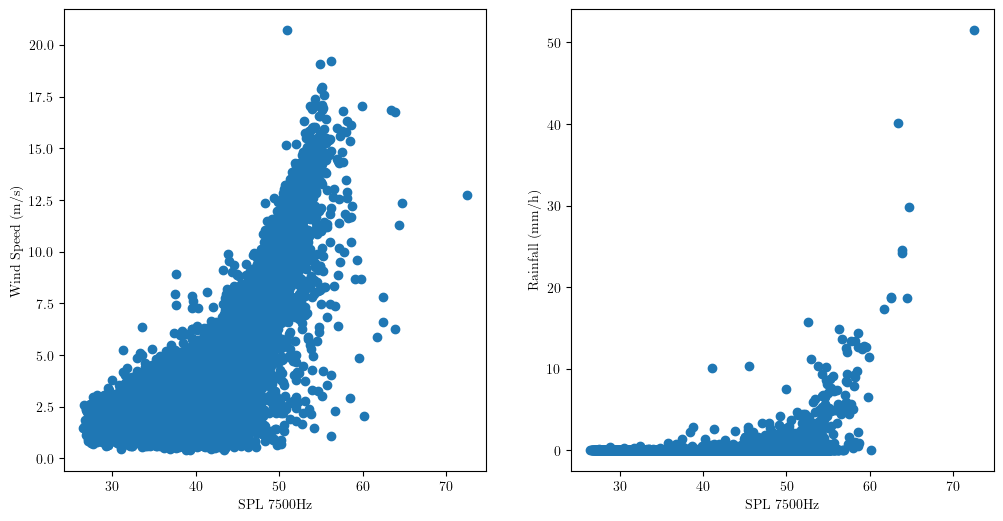

In [15]:
freq = 8000
idx = np.argmin(np.abs(np.array(freqs) - freq))
print(idx, freqs[idx])

fig, axes = plt.subplots(1,2, figsize=(12, 6))
axes[0].scatter(SPL64[:,idx], weather["windSpeed_W1M3A"])
axes[0].set_xlabel(f"SPL {freqs[idx]}Hz")
axes[0].set_ylabel("Wind Speed (m/s)")

axes[1].scatter(SPL64[:,idx], weather["rainfall_W1M3A"])
axes[1].set_xlabel(f"SPL {freqs[idx]}Hz")
axes[1].set_ylabel("Rainfall (mm/h)")
plt.show()

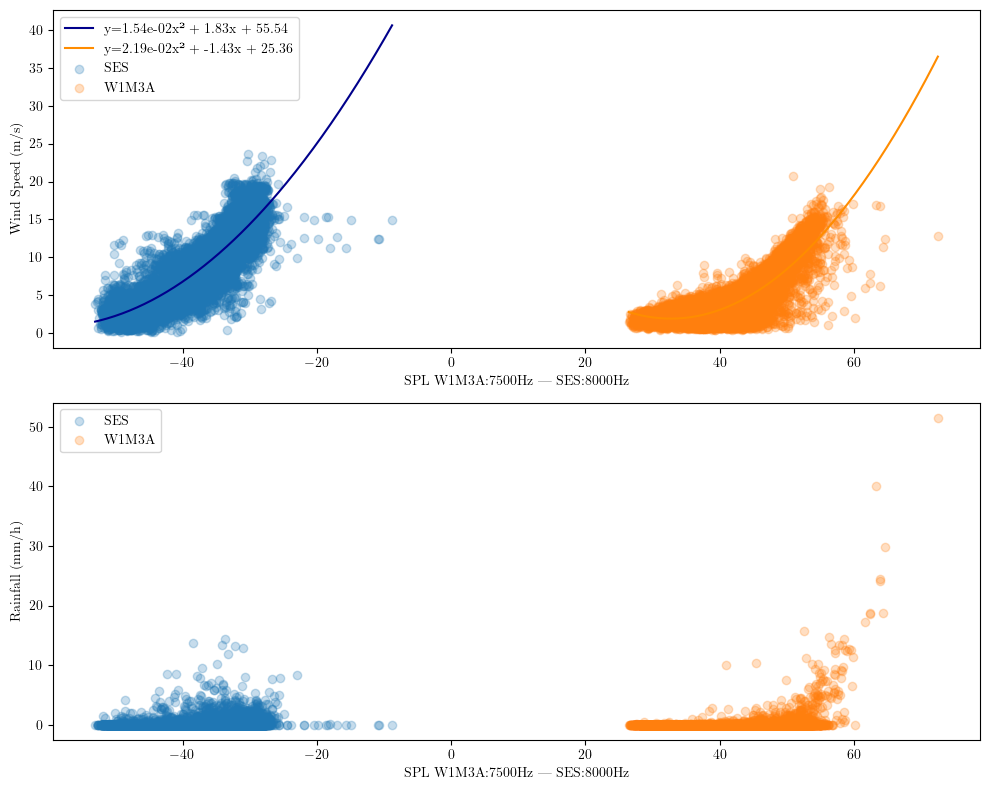

In [19]:
freq = 8000

idx = np.argmin(np.abs(np.array(freqs) - freq))
idx_npz = np.argmin(np.abs(np.array(npz_freqs) - freq))

xSES = df_alldepids["upwards_mean_8000"]
ySES_wind = df_alldepids["wind_speed"]
coeffsSES = np.polyfit(xSES, ySES_wind, deg=2) 
x_regSES = np.linspace(xSES.min(), xSES.max(), 200)
y_regSES_wind = np.polyval(coeffsSES, x_regSES)

xW1M3A = SPL64[:,idx]
yW1M3A_wind = weather["windSpeed_W1M3A"]
coeffsW1M3A = np.polyfit(xW1M3A, yW1M3A_wind, deg=2) 
x_regW1M3A = np.linspace(xW1M3A.min(), xW1M3A.max(), 200)
y_regW1M3A_wind = np.polyval(coeffsW1M3A, x_regW1M3A)

SPL_mean = [x[:,25].mean() for x in X]

fig, axes = plt.subplots(2,1, figsize=(10, 8))

axes[0].plot(x_regSES, y_regSES_wind, color='darkblue', label=f'y={coeffsSES[0]:.2e}x² + {coeffsSES[1]:.2f}x + {coeffsSES[2]:.2f}')
axes[0].plot(x_regW1M3A, y_regW1M3A_wind, color='darkorange', label=f'y={coeffsW1M3A[0]:.2e}x² + {coeffsW1M3A[1]:.2f}x + {coeffsW1M3A[2]:.2f}')
axes[0].scatter(xSES, ySES_wind,alpha=0.25, label='SES')#, marker='o', fc='none', color="black",lw=1.5)
# axes[0].scatter(SPL_mean, ws, marker='o', fc='none', label='SES', color="black",lw=1.5)
axes[0].scatter(SPL64[:,idx], weather["windSpeed_W1M3A"], label='W1M3A',alpha=0.25)#, marker="x", color="black")
axes[0].set_ylabel("Wind Speed (m/s)")
axes[0].set_xlabel(f"SPL W1M3A:{freqs[idx]}Hz | SES:{int(npz_freqs[idx_npz])}Hz")


axes[1].scatter(df_alldepids["upwards_mean_8000"], df_alldepids["precipitation_GPM"],alpha=0.25, label='SES')#, marker='o', fc='none', color="black",lw=1.5)
# axes[1].scatter(SPL_mean, rr, marker='o', fc='none', label='SES', color="black",lw=1.5)
axes[1].scatter(SPL64[:,idx], weather["rainfall_W1M3A"], label='W1M3A',alpha=0.25)#, marker="x", color="black")
axes[1].set_ylabel("Rainfall (mm/h)")
axes[1].set_xlabel(f"SPL W1M3A:{freqs[idx]}Hz | SES:{int(npz_freqs[idx_npz])}Hz")

for ax in axes :
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()